### References:

Darmet, L., Ladouce, S., & Dehais, F. (2023). **Shortened calibration of code-VEP based BCI by improved deep learning 
architecture and golden subjects pre-training.** *In 11th International IEEE EMBS Conference on Neural Engineering.* 

Source: https://github.com/neuroergoISAE/offline_cVEP_bitwise

Thielen, J., Marsman, P., Farquhar, J., & Desain, P. (2021). **From full calibration to zero training for a code-modulated
visual evoked potentials for brain–computer interface**. *Journal of Neural Engineering, 18(5), 056007.*

Source: https://gitlab.socsci.ru.nl/jthielen/pynt/-/blob/main/examples

Sebastian Nagel

Source: https://github.com/thecodingdad/eeg2code

Teulings, D.E.J. David (2022).  **an-application-of-recurrency-to-eeg2code-deep-learning**

Source: https://gitlab.socsci.ru.nl/D.Teulings/an-application-of-recurrency-to-eeg2code-deep-learning/-/tree/master

In [1]:
# the path to the dataset
path = 'D:/Dataset'
pynt_path = 'D:/Dataset/Thielen/pynt'

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pynt
import keras
import sys
import scipy.io as sio
import tensorflow as tf
import time
import seaborn
from keras.optimizers import adam
from tensorflow.python.keras import backend
from tensorflow.keras.models import load_model
from keras import optimizers
from keras import initializers
from keras.models import load_model
from keras.models import Sequential
from keras.layers import (Input,
                          InputLayer,
                          GRU,
                          RNN,
                          LSTM,
                          Reshape,
                          SimpleRNN,
                          Conv2D,
                          MaxPooling2D,
                          Permute,
                          Flatten, 
                          Dense,
                          BatchNormalization, 
                          Activation,
                          Dropout
                         )
from scipy.io import loadmat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_decomposition import CCA
from tensorflow.python.keras import backend
from tensorflow.keras.models import load_model

subject = "sub-01" 

### Load data

In [3]:
def load_data(subject):
    fn = os.path.join(path, "derivatives300", "offline", subject, f"{subject}_gdf.npz")
    tmp = np.load(fn)
    X = tmp['X']
    V = tmp['V']
    y = tmp['y']
    fs = tmp["fs"]
    # Print data dimensions
    print("X shape:", X.shape, ", type:", X.dtype)  # EEG time-series: trials x channels x samples
    print("y shape:", y.shape, ", type:", y.dtype)  # Labels: trials
    print("V shape:", V.shape, ", type:", V.dtype)  # Codes: samples x classes
    # Extract data dimensions
    n_trials, n_channels, n_samples = X.shape
    print("n_channels: ", n_channels)
    print("n_samples: ", n_samples)
    print("n_trials: ", n_trials)
    n_classes = V.shape[1]
    print("n_classes: ", n_classes)
    # Print sample rate
    print("fs:", fs)
    # Read cap file
    capfile = os.path.join(pynt_path, "capfiles", "nt_cap8.loc")
    fid = open(capfile, "r")
    channels = []
    for line in fid.readlines():
        channels.append(line.split("\t")[-1].strip())
    # Print channels    
    print("channels:", channels)
    return X, V, y, fs, channels, n_channels, n_samples, n_trials, n_classes

### Visualize Data

X shape: (100, 8, 9450) , type: float32
y shape: (100,) , type: uint8
V shape: (630, 20) , type: uint8
n_channels:  8
n_samples:  9450
n_trials:  100
n_classes:  20
fs: 300
channels: ['Fpz', 'T7', 'O1', 'POz', 'Oz', 'Iz', 'O2', 'T8']


Text(0.5, 1.0, 'Single-trial multi-channel EEG time-series (trial 0)')

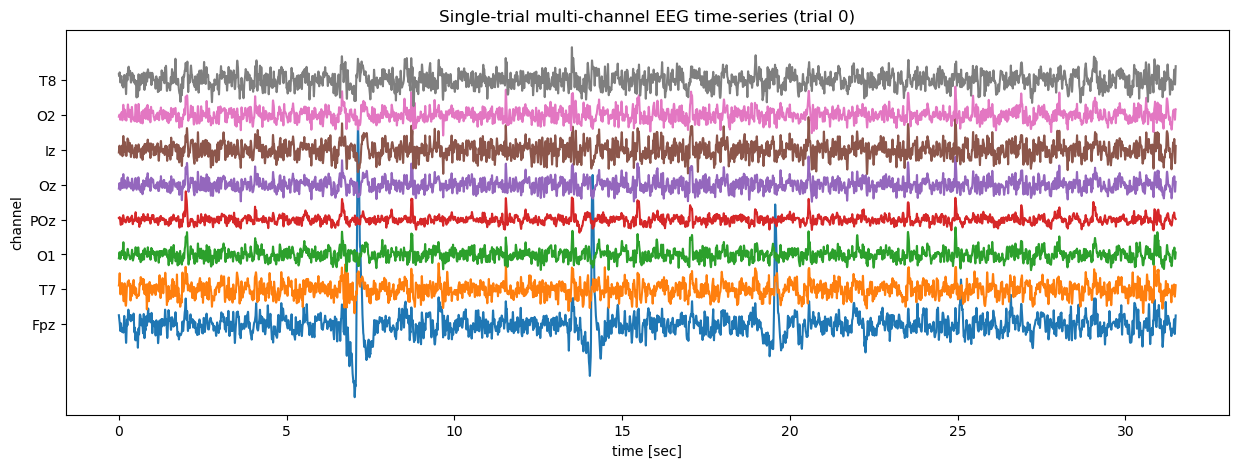

In [4]:
X, V, y, fs, channels, n_channels, n_samples, n_trials, n_classes = load_data(subject)

# Visualize EEG data
i_trial = 0
plt.figure(figsize=(15, 5))
plt.plot(np.arange(0, n_samples) / fs, 25e-6 * np.arange(n_channels) + X[i_trial, :, :].T)
plt.yticks(25e-6 * np.arange(n_channels), channels)
plt.xlabel("time [sec]")
plt.ylabel("channel")
plt.title(f"Single-trial multi-channel EEG time-series (trial {i_trial})")

Text(0.5, 1.0, 'Single-trial labels')

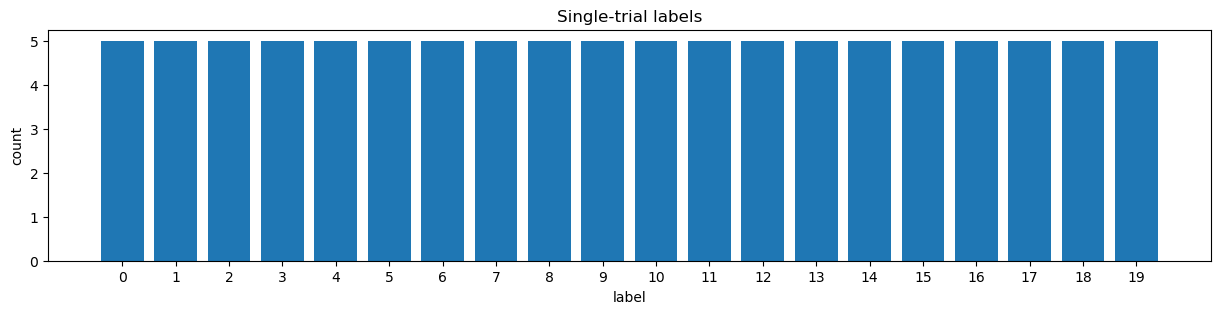

In [5]:
 # Visualize labels
plt.figure(figsize=(15, 3))
hist = np.histogram(y, bins=np.arange(n_classes+1))[0]
plt.bar(np.arange(n_classes), hist)
plt.xticks(np.arange(n_classes))
plt.xlabel("label")
plt.ylabel("count")
plt.title("Single-trial labels")

Text(0.5, 1.0, 'Code time-series')

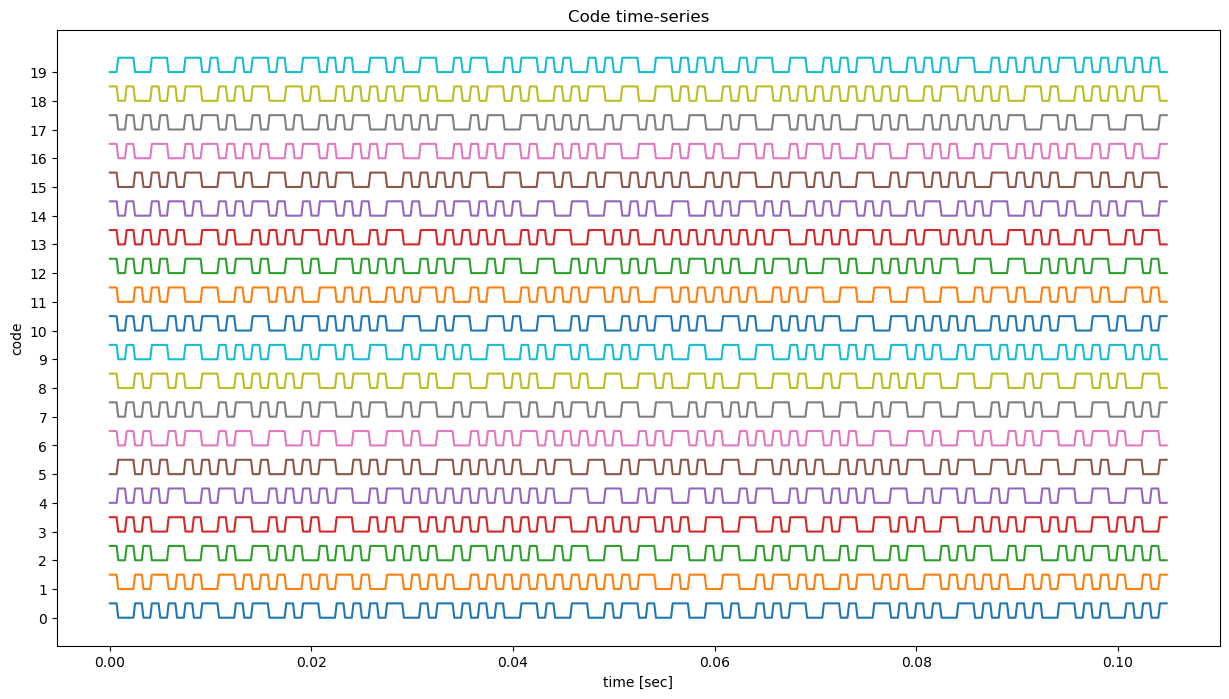

In [6]:
# Visualize codes
codes = V  # upsample to better visualize the sharp edges
plt.figure(figsize=(15, 8))
plt.plot(np.arange(0, codes.shape[0]) / (20 * fs), 2 * np.arange(n_classes) + codes)
plt.yticks(2 * np.arange(n_classes), np.arange(n_classes))
plt.xlabel("time [sec]")
plt.ylabel("code")
plt.title("Code time-series")

### Events

The first step towards applying the reconvolution encoding model, is to convert the codes to events. The event-type, or event-definition is set manually. In general, one should, from a neuroscientific perspective, find an event-definition that the brain might be responding to. Commonly, the "duration" event-type is used, which defines every run-length as a separate event. Specifically, this means that the bit-sequences, which contain only two different run-lengths (short: 1, long: 11), will be split into two event-sequences, one for each event. Such event-sequence denotes when that specific event occurs.

In [7]:
# the bit-sequences, which contain only two different run-lengths (short: 1, long: 11), will be split into two event-sequences, one for each event. Such event-sequence denotes when that specific event occurs.
# Get events
E, events = pynt.utilities.event_matrix(V, event="duration", onset_event=True)
    
print("E: shape:", E.shape, ", type:", E.dtype)  # samples x events x classes
print("Events:", events)

E: shape: (3, 630, 20) , type: float64
Events: (5, 10, 'onset')


Text(0.5, 1.0, 'Event matrix (code 0)')

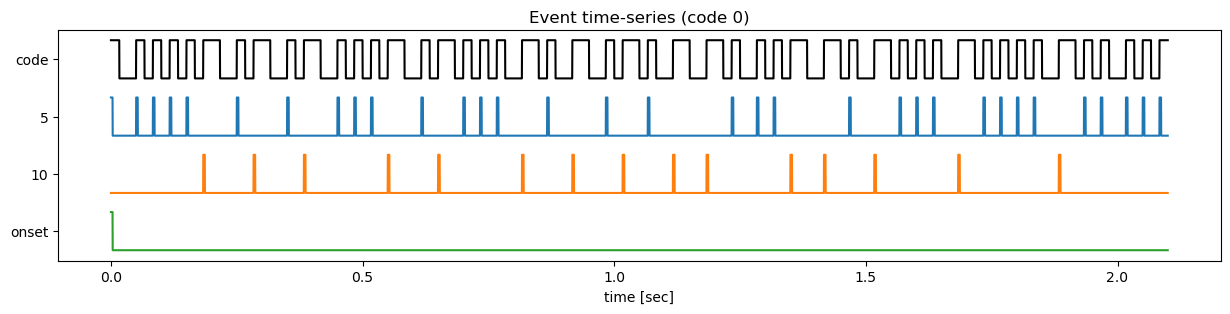

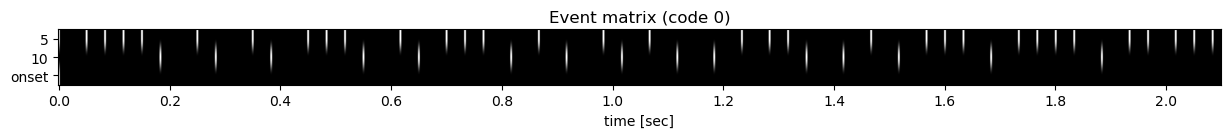

In [8]:
# Visualize event time-series
i_class = 0
Vu = V.repeat(20, axis=0)  # upsample to better visualize the sharp edges
Eu = E.repeat(20, axis=1)  # upsample to better visualize the sharp edges
plt.figure(figsize=(15, 3))
plt.plot(np.arange(0, Vu.shape[0]) / (20*fs), Vu[:, i_class], "k")
for i in range(E.shape[0]):
    plt.plot(np.arange(0, Eu.shape[1]) / (20*fs), -1.5 * (1 + i) + Eu[i, :, i_class])
plt.yticks(-1.5 * np.arange(0, 1 + E.shape[0]) + 0.5, ("code",) + events)
plt.xlabel("time [sec]")
plt.ylabel("")
plt.title(f"Event time-series (code {i_class})")

# Visualize event matrix
i_code = 0
plt.figure(figsize=(15, 3))
plt.imshow(E[:, :, i_code], cmap="gray")
plt.gca().set_aspect(10)
plt.xticks(np.arange(0, V.shape[0], 60), np.arange(0, V.shape[0], 60) / fs)
plt.yticks(np.arange(E.shape[0]), events)
plt.xlabel("time [sec]")
plt.title(f"Event matrix (code {i_code})")

### Structure matrices
The second step is to construct so-called structure matrices. These are a kind of design matrices that apart from the onset of an event as listed in the event matrix also model the length of an event (and as such the overlap between events). It follows a typical Toeplitz structure with ones on diagonals. In the case of multiple events, the structure matrices for individual events are concatenated.

In [11]:
# Create structure matrix
transient_size = int(0.3 * fs)
M = pynt.utilities.structure_matrix(E, transient_size)

# Print dimensions
print("M: shape:", M.shape, ", type:", M.dtype)  # samples x events*event-samples x classes

M: shape: (270, 630, 20) , type: uint8


Text(0.5, 1.0, 'Structure matrix (code 0)')

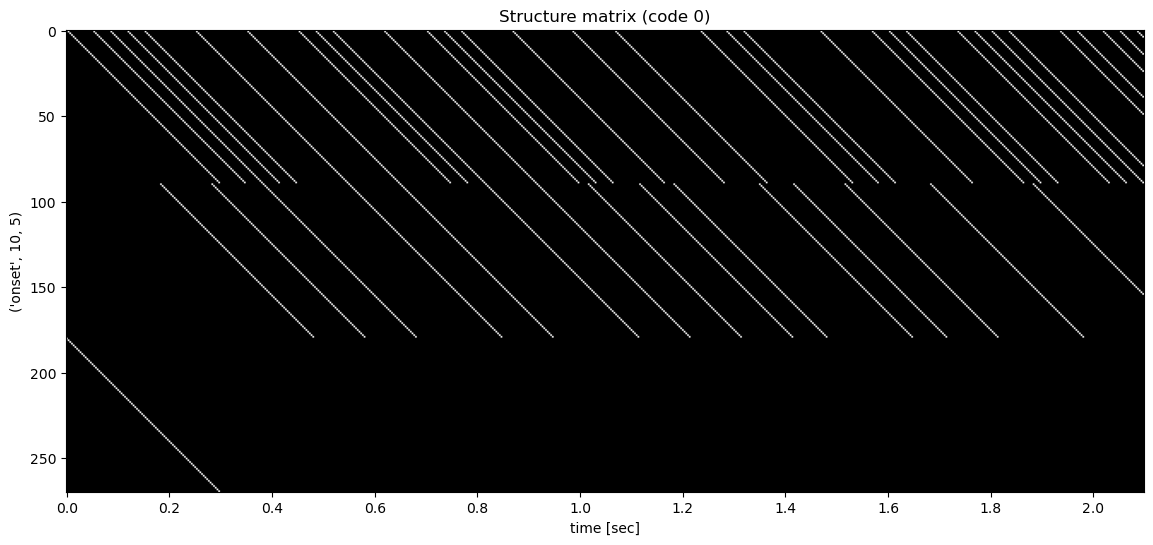

In [14]:
 # Plot structure matrix
i_code = 0
plt.figure(figsize=(15, 6))
plt.imshow(M[:, :, i_code], cmap="gray")
plt.xticks(np.arange(0, V.shape[0], 60), np.arange(0, V.shape[0], 60) / fs)
plt.xlabel("time [sec]")
plt.ylabel(events[::-1])
plt.title(f"Structure matrix (code {i_code})")

### Reconvolution
Now, finally, we can come to the interesting bit. Here, we will apply the reconvolution method to the entire dataset, just to see how it works, and to visualize what it learns. The reconvolution learns both a spatial filter as well as a temporal response in one go using a canonical correlation analysis (CCA). To be precise, the CCA optimizes the correlation between w⊤X and r⊤M. Here, w is the spatial filter so that w⊤X is spatially filtered data, and r is the response vector so that r⊤M is the predicted response. Therefore, this CCA optimizes a spatial filter and response vector, such that the predicted response looks most like spatially filtered EEG. Note, the structure matrix that we use, contains the structure matrices of individual events concatenated. This means that the learned response vector will consist of concatenated responses, one for each event. Also note, that we use a dataset that contains many trials. The trick here is to concatenate all those trials after each other to form one big time-series, and input this into the CCA. (Alternatively, one could compute ERPs, i.e. average repetitions of the same class-label).


In [15]:
 # Perform CCA decomposition
transient_size = 0.3
rcca = pynt.classifiers.rCCA(codes=V, fs=fs, event="duration", transient_size=transient_size, onset_event=True)
w, r = rcca._fit_w_r(X, y)

print("w: shape:", w.shape, ", type:", w.dtype)
print("r: shape:", r.shape, ", type:", r.dtype)

w: shape: (8,) , type: float64
r: shape: (270,) , type: float64


Text(0.5, 1.0, 'transient responses')

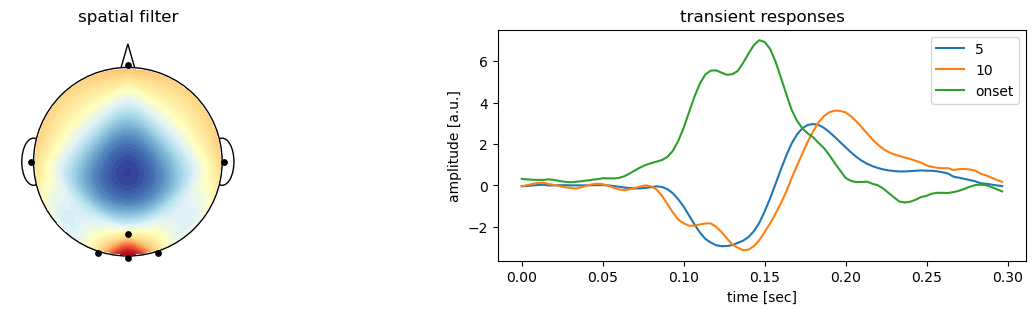

In [16]:
 # Plot CCA filters
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
capfile = os.path.join(pynt_path, "capfiles", "nt_cap8.loc")
pynt.utilities.topoplot(w, capfile, ax=ax[0])
ax[0].set_title("spatial filter")
tmp = np.reshape(r, (len(rcca.events_), -1))
for i in range(len(rcca.events_)):
    ax[1].plot(np.arange(int(transient_size * fs)) / fs, tmp[i, :])
ax[1].legend(rcca.events_)
ax[1].set_xlabel("time [sec]")
ax[1].set_ylabel("amplitude [a.u.]")
ax[1].set_title("transient responses")

### Offline classification with cross-validation

Given that we can optimize a spatial filter and a response vector, we can define the classification criterion, which is a template matching classifier defined as follows: y^​=argmaxi​ρ(w⊤X,ti​), where ti​=rMi​ is the predicted response (i.e. template) of class i. Specifically, for a new single-trial that we want to classify, we first spatially filter it, and then compare it to the predicted responses which we use as templates. The comparison is done by computing the correlation of the spatially filtered single-trial with all templates, and selecting the one with the highest correlation, as that is the one that the single-trial is most similar to.To estimate a generalization performance, a chronological cross-validation is performed below. Note, the dataset contains single-trials of 31.5 seconds long. For many participants in the dataset, if all data is used, this leads to 100% accuracy. A new parameter is introduced here, that cuts the single-trials to shorter lengths. 
Ideally, this parameter is explored, to estimate a so-called decoding curve.

Accuracy: avg=100.0 with std=0.00
ITR: avg=49.9 with std=0.00


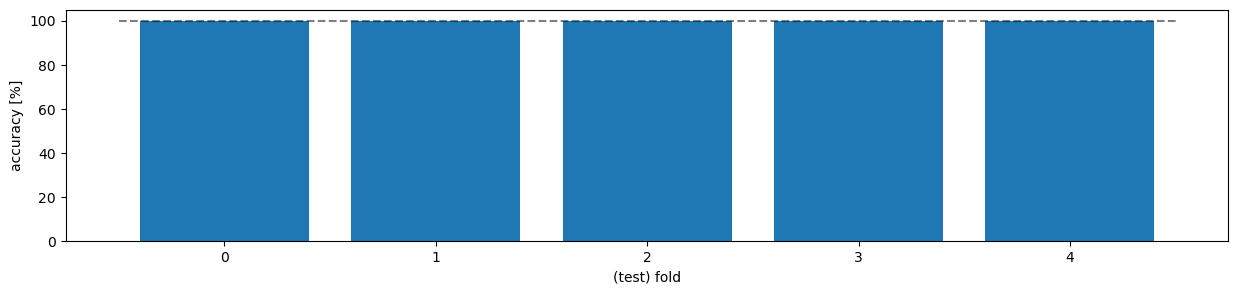

In [17]:
from sklearn.model_selection import cross_val_score
# Set trial duration
trialtime = 4.2
intertrialtime = 1.0
n_samples = int(trialtime * fs)
n_folds = 5

# Setup model
rcca = pynt.classifiers.rCCA(codes=V, fs=fs, event="duration", transient_size=0.3, onset_event=True)

# Cross-validation
accuracy = cross_val_score(rcca, X[:, :, :n_samples], y, cv=n_folds) * 100

# Compute ITR
itr = pynt.utilities.itr(V.shape[1], accuracy/100, trialtime + intertrialtime)
    
# Plot accuracy (over folds)
plt.figure(figsize=(15, 3))
plt.bar(np.arange(n_folds), accuracy)
plt.hlines(np.mean(accuracy), -.5, n_folds-0.5, linestyle='--', color="k", alpha=0.5)
plt.xlabel("(test) fold")
plt.ylabel("accuracy [%]")

# Print accuracy (average and standard deviation over folds)
print(f"Accuracy: avg={accuracy.mean():.1f} with std={accuracy.std():.2f}")
print(f"ITR: avg={itr.mean():.1f} with std={itr.std():.2f}")

Accuracy: avg=100.0 with std=0.00
ITR: avg=49.9 with std=0.00


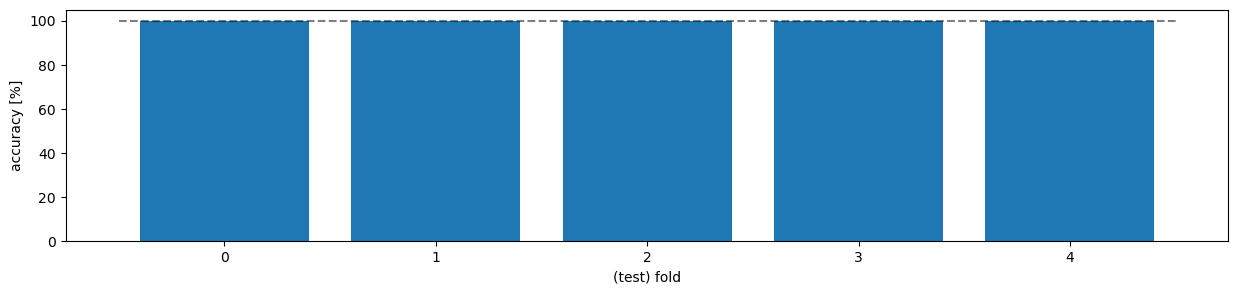

In [18]:
 # Set trial duration
trialtime = 4.2
intertrialtime = 1.0
n_samples = int(trialtime * fs)
transient_size = 0.3

# Setup cross-validation
n_folds = 5
folds = np.repeat(np.arange(n_folds), int(n_trials / n_folds))

# Loop folds
accuracy = np.zeros(n_folds)
for i_fold in range(n_folds):
    
    # Split data to train and valid set
    X_trn, y_trn = X[folds != i_fold, :, :n_samples], y[folds != i_fold]
    X_tst, y_tst = X[folds == i_fold, :, :n_samples], y[folds == i_fold]
    
    # Train template-matching classifier
    rcca = pynt.classifiers.rCCA(codes=V, fs=fs, event="duration", transient_size=transient_size, onset_event=True)
    rcca.fit(X_trn, y_trn)
    
    # Apply template-matching classifier
    yh_tst = rcca.predict(X_tst)
        
    # Compute accuracy
    accuracy[i_fold] = 100 * np.mean(yh_tst == y_tst)

# Compute ITR
itr = pynt.utilities.itr(V.shape[1], accuracy/100, trialtime + intertrialtime)
    
# Plot accuracy (over folds)
plt.figure(figsize=(15, 3))
plt.bar(np.arange(n_folds), accuracy)
plt.hlines(np.mean(accuracy), -.5, n_folds-0.5, linestyle='--', color="k", alpha=0.5)
plt.xlabel("(test) fold")
plt.ylabel("accuracy [%]")

# Print accuracy (average and standard deviation over folds)
print(f"Accuracy: avg={accuracy.mean():.1f} with std={accuracy.std():.2f}")
print(f"ITR: avg={itr.mean():.1f} with std={itr.std():.2f}")

### Learning curve

In this section, we will apply the decoder to varying number of training trials, to estimate a so-called learning curve. With this information, one could decide how much training data is required, or compare algorithms on how much training data they require to estimate their parameters.

Text(0.5, 1.0, 'Learning curve')

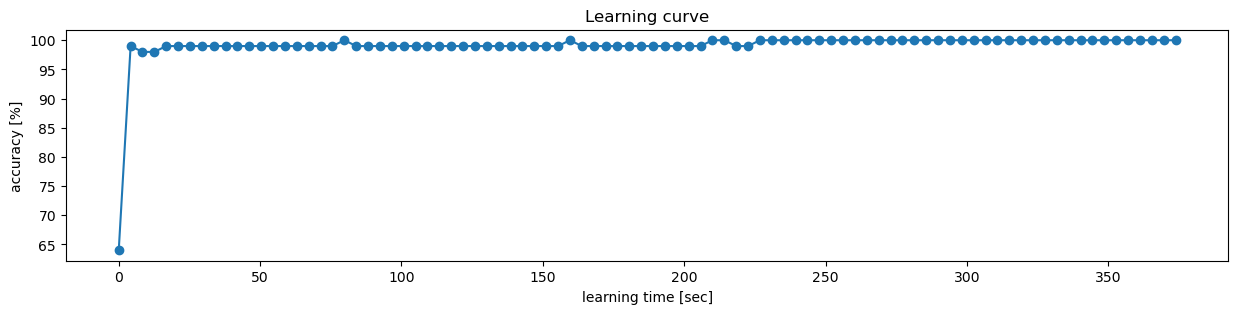

In [19]:
 # Set trial duration
n_samples = int(4.2 * fs)

# Split data to train and test set
n_folds = 10
folds = np.repeat(np.arange(n_folds), int(n_trials / n_folds))
n_train_trials = np.sum(folds != 0)

accuracy = np.zeros((n_folds, n_train_trials))
for i_fold in range(n_folds):

    X_trn, y_trn = X[folds != i_fold, :, :n_samples], y[folds != i_fold]
    X_tst, y_tst = X[folds == i_fold, :, :n_samples], y[folds == i_fold]

    for i_trial in range(n_train_trials):

        # Train classifier
        rcca = pynt.classifiers.rCCA(codes=V, fs=fs, event="duration", transient_size=0.3, onset_event=True)
        rcca.fit(X_trn[:1+i_trial, :, :], y_trn[:1+i_trial])

        # Apply classifier
        yh_tst = rcca.predict(X_tst)

        # Compute accuracy
        accuracy[i_fold, i_trial] = 100 * np.mean(yh_tst == y_tst)

# Plot results
plt.figure(figsize=(15, 3))
plt.plot(np.arange(n_train_trials) * n_samples / fs, np.mean(accuracy, axis=0), linestyle='-', marker='o')
plt.xlabel("learning time [sec]")
plt.ylabel("accuracy [%]")
plt.title("Learning curve")

### Decoding curve

In this section, we will apply the decoder to varying testing trial lengths, to estimate a so-called decoding curve. With this information, one could decide how much testing data is required, or compare algorithms on how much data they need during testing to classify single-trials.

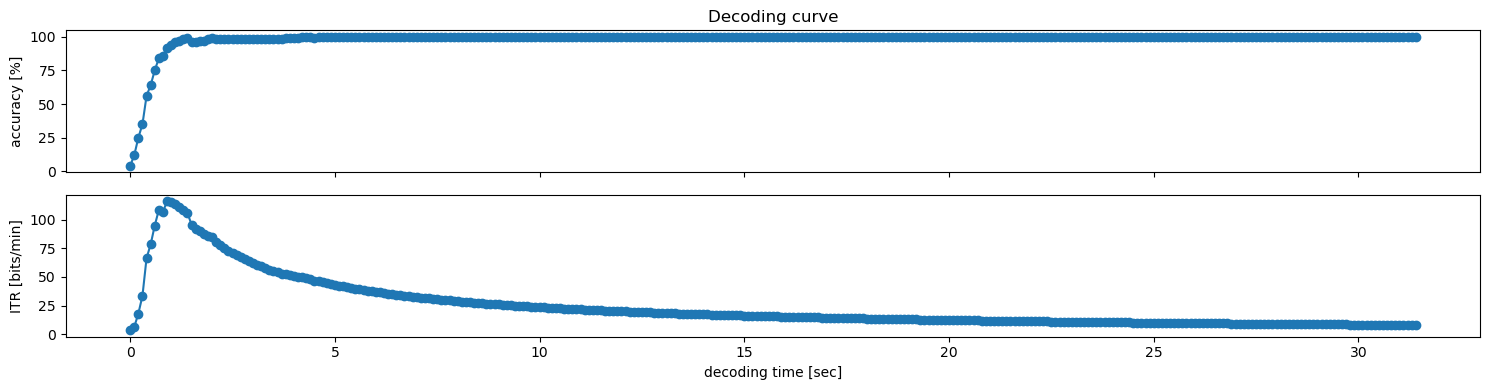

In [20]:
 # Set trial duration
trialtime = 31.5
intertrialtime = 1.0
n_samples = int(trialtime * fs)

# Set decoding curve step size
segment_size = 0.1
n_segments = int(np.floor(n_samples / (segment_size * fs)))

# Split data to train and test set
n_folds = 10
folds = np.repeat(np.arange(n_folds), int(n_trials / n_folds))

accuracy = np.zeros((n_folds, n_segments))
for i_fold in range(n_folds):

    X_trn, y_trn = X[folds != i_fold, :, :n_samples], y[folds != i_fold]
    X_tst, y_tst = X[folds == i_fold, :, :n_samples], y[folds == i_fold]

    # Setup classifier
    rcca = pynt.classifiers.rCCA(codes=V, fs=fs, event="duration", transient_size=0.3, onset_event=True)

    # Train classifier
    rcca.fit(X_trn, y_trn)

    # Loop segments
    for i_segment in range(n_segments):

        # Apply classifier
        n_samples = int((1 + i_segment) * segment_size * fs)
        yh_tst = rcca.predict(X_tst[:, :, :n_samples])

        # Compute accuracy
        accuracy[i_fold, i_segment] = 100 * np.mean(yh_tst == y_tst)
        
time = np.tile(np.arange(0, trialtime, segment_size)[np.newaxis, :], (n_folds, 1))
itr = pynt.utilities.itr(V.shape[1], accuracy/100, time + intertrialtime)
        
# Plot results
fig, ax = plt.subplots(2, 1, figsize=(15, 4), sharex=True)
ax[0].plot(time[0, :], np.mean(accuracy, axis=0), linestyle='-', marker='o')
ax[1].plot(time[0, :], np.mean(itr, axis=0), linestyle='-', marker='o')
ax[1].set_xlabel("decoding time [sec]")
ax[0].set_ylabel("accuracy [%]")
ax[1].set_ylabel("ITR [bits/min]")
ax[0].set_title("Decoding curve")
fig.tight_layout()


### Analyse all participants

In [21]:
n_subjects = 30
subjects = [f"sub-{1 + i:02d}" for i in range(n_subjects)]

# Set trial duration
trialtime = 4.2
n_trials = 100

# Set folds
n_folds = 10
folds = np.repeat(np.arange(n_folds), int(n_trials / n_folds))

# Loop participants
accuracy = np.zeros((n_subjects, n_folds))
for i_subject in range(n_subjects):
    subject = subjects[i_subject]

    # Load data
    fn = os.path.join(path, "derivatives", "offline", subject, f"{subject}_gdf.npz")
    tmp = np.load(fn)
    fs = tmp["fs"]
    X = tmp["X"][:n_trials, :, :int(trialtime * fs)]
    y = tmp["y"][:n_trials]
    V = tmp["V"]
    
    # Cross-validation
    for i_fold in range(n_folds):
        
        X_trn, y_trn = X[folds!=i_fold, :, :], y[folds!=i_fold]
        X_tst, y_tst = X[folds==i_fold, :, :], y[folds==i_fold]

        # Train classifier
        rcca = pynt.classifiers.rCCA(codes=V, fs=fs, event="duration", transient_size=0.3, onset_event=True)
        rcca.fit(X_trn, y_trn)

        # Apply classifier
        yh_tst = rcca.predict(X_tst)

        # Compute accuracy
        accuracy[i_subject, i_fold] = 100 * np.mean(yh_tst == y_tst)
    
# Add average to accuracies
subjects += ["avg"]
avg = np.mean(accuracy, axis=0, keepdims=True)
accuracy = np.concatenate((accuracy, avg), axis=0)

# Plot accuracy
plt.figure(figsize=(18, 4))
plt.axhline(accuracy.mean(), linestyle="--", color="k", alpha=0.5)
avg = accuracy.mean(axis=1)
std = accuracy.std(axis=1)
plt.bar(np.arange(1 + n_subjects) + 0.3, avg, 0.5, yerr=std)
plt.table(cellText=[np.round(avg, 1), np.round(std, 1)], 
          loc='bottom', rowLabels=["avg", "std"], 
          colLabels=subjects, cellLoc="center")
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.xticks([])
plt.ylabel("accuracy [%]")
plt.xlim([-0.25, n_subjects + 0.75])

print(f"Average accuracy: {avg.mean():.1f}")

FileNotFoundError: [Errno 2] No such file or directory: 'D:/Dataset\\derivatives\\offline\\sub-01\\sub-01_gdf.npz'

### Epoch decoding & ERP

In [ ]:
# Slice trials to epochs
epoch_size = int(0.3 * fs)
step_size = int(1 / 60 * fs)
X_sliced, y_sliced = pynt.utilities.trials_to_epochs(X, y, V, epoch_size, step_size)

print("X_sliced: shape:", X_sliced.shape, ", type:", X_sliced.dtype)
print("y_sliced: shape:", y_sliced.shape, ", type:", y_sliced.dtype)

 # Inspect sliced labels
plt.figure(figsize=(15, 3))
hist = np.histogram(y_sliced, bins=np.arange(2+1))[0]
plt.bar(np.arange(2), hist)
plt.xticks(np.arange(2), ["non-target (no flash)", "target (flash)"])
plt.xlabel("label")
plt.ylabel("count")
plt.title("Epoch labels")

print("Number of flash epochs:", np.sum(y_sliced == 1))
print("Number of non-flash epochs:", np.sum(y_sliced == 0))

print("Number of flash epochs:", np.sum(y_sliced == 1))
print("Number of non-flash epochs:", np.sum(y_sliced == 0))

 # Compute ERPs
erp_noflash = np.mean(X_sliced[y_sliced == 0, :, :], axis=0)
erp_flash = np.mean(X_sliced[y_sliced == 1, :, :], axis=0)

 # Visualize temporal response per channel
fig, ax = plt.subplots(n_channels, 1, figsize=(15, 2*n_channels), sharex=True, sharey=True)
for i_channel in range(n_channels):
    ax[i_channel].plot(np.arange(erp_noflash.shape[1]) / fs, erp_noflash[i_channel, :], label="non-target")
    ax[i_channel].plot(np.arange(erp_flash.shape[1]) / fs, erp_flash[i_channel, :], label="target")
    ax[i_channel].set_title(channels[i_channel])
    ax[i_channel].set_ylabel("amplitude [V]")
ax[0].legend()
ax[-1].set_xlabel("time [sec]")

### LDA

In [ ]:
# Set trial duration
n_samples = int(4.2 * fs)

# Set epoch size
epoch_size = int(0.3 * fs)
step_size = int(1 / 60 * fs)

# Setup cross-validation
n_folds = 5
folds = np.repeat(np.arange(n_folds), n_trials / n_folds)

# Set up codebook for trial classification
n = int(np.ceil(n_samples / V.shape[0]))
_V = np.tile(V, (n, 1)).astype("float32")[:n_samples-epoch_size:step_size]

# Setup LDA
lda = LinearDiscriminantAnalysis(solver="eigen", shrinkage="auto")

# Loop folds
accuracy_epoch = np.zeros(n_folds)
accuracy_trial = np.zeros(n_folds)
for i_fold in range(n_folds):
    
    # Split data to train and valid set
    X_trn, y_trn = X[folds != i_fold, :, :n_samples], y[folds != i_fold]
    X_tst, y_tst = X[folds == i_fold, :, :n_samples], y[folds == i_fold]

    # Slice trials to epochs
    X_sliced_trn, y_sliced_trn = pynt.utilities.trials_to_epochs(X_trn, y_trn, V, epoch_size, step_size)
    X_sliced_tst, y_sliced_tst = pynt.utilities.trials_to_epochs(X_tst, y_tst, V, epoch_size, step_size)
    
    # Train LDA (on epoch level)
    # N.B.: spatio-temporal features are flattened
    # N.B.: all epochs of all trials are concatenated
    lda.fit(X_sliced_trn.reshape((-1, n_channels * epoch_size)), y_sliced_trn.flatten())

    # Apply LDA (on epoch level)
    yh_sliced_tst = lda.predict(X_sliced_tst.reshape((-1, n_channels * epoch_size)))
    
    # Compute accuracy (on epoch level)
    accuracy_epoch[i_fold] = 100 * np.mean(yh_sliced_tst == y_sliced_tst.flatten())

    # Apply LDA (on trial level)
    ph_tst = lda.predict_proba(X_sliced_tst.reshape((-1, n_channels * epoch_size)))[:, 1]
    ph_tst = np.reshape(ph_tst, y_sliced_tst.shape)
    rho = pynt.utilities.correlation(ph_tst, _V.T)
    yh_tst = np.argmax(rho, axis=1)
    accuracy_trial[i_fold] = 100 * np.mean(yh_tst == y_tst)
    
# Print accuracy (average and standard deviation over folds)
print("Epoch: avg={:.1f} with std={:.2f}".format(accuracy_epoch.mean(), accuracy_epoch.std()))
print("Trial: avg={:.1f} with std={:.2f}".format(accuracy_trial.mean(), accuracy_trial.std()))

# Plot epoch accuracy (over folds)
plt.figure(figsize=(15, 3))
plt.bar(np.arange(n_folds), accuracy_epoch)
plt.hlines(np.mean(accuracy_epoch), -.5, n_folds-0.5, color="k")
plt.xlabel("(test) fold")
plt.ylabel("accuracy [%]")
plt.title("Classification accuracy (epoch): avg={:.2f} std={:.2f}".format(
    np.mean(accuracy_epoch), np.std(accuracy_epoch)))

# Plot trial accuracy (over folds)
plt.figure(figsize=(15, 3))
plt.bar(np.arange(n_folds), accuracy_trial)
plt.hlines(np.mean(accuracy_trial), -.5, n_folds-0.5, color="k")
plt.xlabel("(test) fold")
plt.ylabel("accuracy [%]")
plt.title("Classification accuracy (trial): avg={:.2f} std={:.2f}".format(
    np.mean(accuracy_trial), np.std(accuracy_trial)))

In [ ]:
# Set trial duration
n_samples = int(4.2 * fs)

# Set epoch size
epoch_size = int(0.3 * fs)
step_size = int(1 / 60 * fs)

# Setup cross-validation
n_folds = 5
folds = np.repeat(np.arange(n_folds), n_trials / n_folds)

# Set up codebook for trial classification
n = int(np.ceil(n_samples / V.shape[0]))
_V = np.tile(V, (n, 1)).astype("float32")[:n_samples-epoch_size:step_size]

# Setup LDA
lda = LinearDiscriminantAnalysis(solver="eigen", shrinkage="auto")

# Setup CCA
cca = CCA(n_components=1)

# Loop folds
accuracy_epoch = np.zeros(n_folds)
accuracy_trial = np.zeros(n_folds)
for i_fold in range(n_folds):
    
    # Split data to train and valid set
    X_trn, y_trn = X[folds != i_fold, :, :n_samples], y[folds != i_fold]
    X_tst, y_tst = X[folds == i_fold, :, :n_samples], y[folds == i_fold]

    # Slice trials to epochs
    X_sliced_trn, y_sliced_trn = pynt.utilities.trials_to_epochs(X_trn, y_trn, V, epoch_size, step_size)
    X_sliced_tst, y_sliced_tst = pynt.utilities.trials_to_epochs(X_tst, y_tst, V, epoch_size, step_size)
    
    # Train CCA (on epoch level)
    erp_noflash = np.mean(X_sliced_trn[y_sliced_trn == 0, :, :], axis=0, keepdims=True)
    erp_flash = np.mean(X_sliced_trn[y_sliced_trn == 1, :, :], axis=0, keepdims=True)
    erps = np.concatenate((erp_noflash, erp_flash), axis=0)[y_sliced_trn, :, :]
    cca.fit(
        X_sliced_trn.transpose((0, 1, 3, 2)).reshape((-1, n_channels)), 
        erps.transpose((0, 1, 3, 2)).reshape(-1, n_channels))
    w = cca.x_weights_.flatten()
    
    # Apply CCA (on epoch level)
    X_sliced_filtered_trn = np.dot(w, 
        X_sliced_trn.transpose((2, 0, 1, 3)).reshape((n_channels, -1))).reshape(-1, epoch_size)
    X_sliced_filtered_tst = np.dot(w, 
        X_sliced_tst.transpose((2, 0, 1, 3)).reshape((n_channels, -1))).reshape(-1, epoch_size)
    
    # Train LDA (on epoch level)
    # N.B.: spatio-temporal features are flattened
    # N.B.: all epochs of all trials are concatenated
    lda.fit(X_sliced_filtered_trn, y_sliced_trn.flatten())

    # Apply LDA (on epoch level)
    yh_sliced_tst = lda.predict(X_sliced_filtered_tst)
    
    # Compute accuracy (on epoch level)
    accuracy_epoch[i_fold] = 100 * np.mean(yh_sliced_tst == y_sliced_tst.flatten())

    # Apply LDA (on trial level)
    ph_tst = lda.predict_proba(X_sliced_filtered_tst)[:, 1]
    ph_tst = np.reshape(ph_tst, y_sliced_tst.shape)
    rho = pynt.utilities.correlation(ph_tst, _V.T)
    yh_tst = np.argmax(rho, axis=1)
    accuracy_trial[i_fold] = 100 * np.mean(yh_tst == y_tst)
    
# Print accuracy (average and standard deviation over folds)
print("Epoch: {:.1f} accuracy with a standard deviation of {:.2f}".format(
    accuracy_epoch.mean(), accuracy_epoch.std()))
print("Trial: {:.1f} accuracy with a standard deviation of {:.2f}".format(
    accuracy_trial.mean(), accuracy_trial.std()))

# Plot epoch accuracy (over folds)
plt.figure(figsize=(15, 3))
plt.bar(np.arange(n_folds), accuracy_epoch)
plt.hlines(np.mean(accuracy_epoch), -.5, n_folds-0.5, color="k")
plt.xlabel("(test) fold")
plt.ylabel("accuracy [%]")
plt.title("Classification accuracy (epoch): avg={:.2f} std={:.2f}".format(
    np.mean(accuracy_epoch), np.std(accuracy_epoch)))

# Plot trial accuracy (over folds)
plt.figure(figsize=(15, 3))
plt.bar(np.arange(n_folds), accuracy_trial)
plt.hlines(np.mean(accuracy_trial), -.5, n_folds-0.5, color="k")
plt.xlabel("(test) fold")
plt.ylabel("accuracy [%]")
plt.title("Classification accuracy (trial): avg={:.2f} std={:.2f}".format(
    np.mean(accuracy_trial), np.std(accuracy_trial)))